In [1]:
import os
import keras
from keras.applications.inception_v3 import preprocess_input# import inception_v3 as inc_net
from keras.preprocessing import image
from keras.models import load_model
from skimage.io import imread
from skimage.segmentation import mark_boundaries
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.1.6


In [6]:
img_size = 299
data_type = 'flowers'
path_to_labels = os.path.join('labels', data_type+'.txt')
file_name = os.path.join('trainedModels',
                         data_type,
                         'completetrain',
                         '28-06-18 13:29__Epochs12_Steps188_ImageSize299_BatchSize16')
def getHighestID(preds):
    id = 0
    max = -1
    for i in range(len(preds)):
        if preds[i]>max:
            max = preds[i]
            id=i
    return id

def getLabels():
    with open(path_to_labels, 'r') as f:
     myLabels = [line.strip() for line in f]
    return myLabels

def getLabelById(id):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if i == id:
                return line
    raise Exception('ID is not in file')
    
def decode_prediction(preds):
    label_list = getLabels()    
    decoded_list = list()
    decoded_list.append([])
    for i in range(len(label_list)):
        decoded_list[0].append([label_list[i],preds[i]])
    return decoded_list

def getIdByLabel(label):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if label == line.replace('\n',''):
                return i
    raise Exception('Label is not in file')

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [3]:
my_model = load_model(file_name+".h5")
print('Model loaded> '+file_name)

Model loaded> trainedModels/flowers/completetrain/28-06-18 13:29__Epochs12_Steps188_ImageSize299_BatchSize16


In [4]:
if data_type == 'mushrooms':
    images = transform_img_fn([os.path.join('data','Amanita muscaria.jpg'),
                           os.path.join('data','Tylopilus felleus.jpg'),
                           os.path.join('data','Suillus grevillei var. grevillei.jpg'),
                           os.path.join('data','Tricholomopsis rutilans.jpg'),
                           os.path.join('data','Xerocomus subtomentosus.jpg'),
                           os.path.join('data','Lepista nuda.jpg')
                          ])
elif data_type == 'flowers':
    images = transform_img_fn([os.path.join('data','daisy.jpg'),
                           os.path.join('data','danelion.jpg'),
                           os.path.join('data','rose.jpg'),
                           os.path.join('data','sunflowers.jpg'),
                           os.path.join('data','tulips.jpg')
                          ])
preds = my_model.predict(images)

['daisy', 0.9998398]
['sunflowers', 9.4030744e-05]
['dandelion', 6.441153e-05]
['tulips', 1.385027e-06]
['roses', 3.486548e-07]


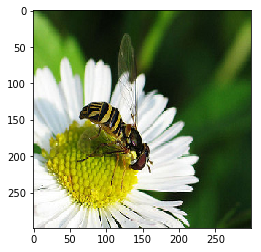

['sunflowers', 0.98496115]
['dandelion', 0.014926201]
['daisy', 0.00010646282]
['tulips', 5.7035263e-06]
['roses', 3.6955944e-07]


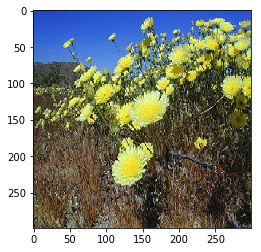

['roses', 0.9989808]
['tulips', 0.0006232256]
['daisy', 0.00039089788]
['sunflowers', 3.6786369e-06]
['dandelion', 1.4176621e-06]


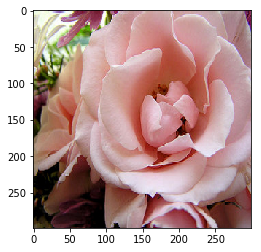

['sunflowers', 1.0]
['dandelion', 9.207763e-15]
['daisy', 2.1896343e-20]
['roses', 2.0706542e-20]
['tulips', 2.4263675e-21]


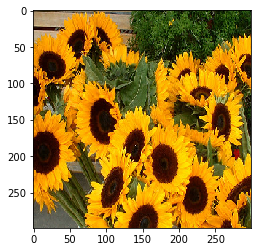

['tulips', 0.9946345]
['sunflowers', 0.0053654555]
['roses', 1.6966803e-08]
['daisy', 1.778098e-09]
['dandelion', 2.8137498e-11]


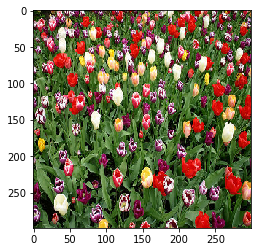

In [7]:
for i in range(len(images)):
    preds_with_labels = decode_prediction(preds[i])[0]
    preds_with_labels = sorted(preds_with_labels,key=lambda l:l[1], reverse=True)
    plt.figure()
    plt.imshow(images[i]/2 +0.5)    
    for x in preds_with_labels[:5]:
        print(x)
    plt.show()

In [8]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [9]:
explainer = lime_image.LimeImageExplainer()

In [10]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explantions = list()
for image in images:
    explantions.append(explainer.explain_instance(image, my_model.predict, hide_color=None, num_samples=1000))

CPU times: user 1min 5s, sys: 6.43 s, total: 1min 11s
Wall time: 1min 8s


daisy
 / 


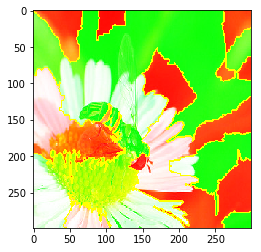

sunflowers
 / 


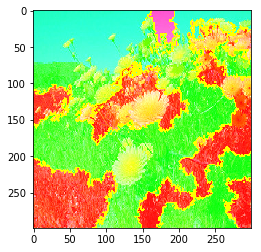

roses
 / 


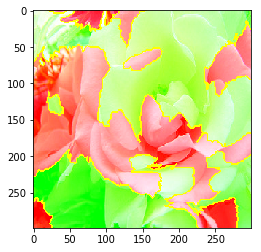

sunflowers
 / 


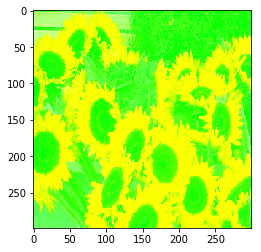

tulips / 


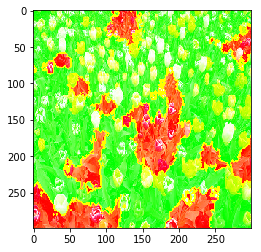

In [12]:
for i in range(len(explantions)):
    temp, mask = explantions[i].get_image_and_mask(getHighestID(preds[i]),
                                                   positive_only=False,
                                                   hide_rest=True,
                                                   num_features=100)
    print(getLabelById(getHighestID(preds[i])) + " / ") #ToDO: getFileName
    plt.figure()
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()